In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

## First we'll deal with a sample of the IMDB data which will be followed by the actual dataset

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb_sample/texts.csv')]

In [4]:
df = pd.read_csv(path/'texts.csv')

In [6]:
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [9]:
df['text'][5]

"From the start, you know how this movie will end. It's so full of clichés your typical NRA member will not even like this movie. I give it 2 out of 10, only because of the acting of William Benton. I can't believe people voted 6+ for this movie. It's so biased towards a 'certain point of view' (once a thief...). People aren't born bad. Neither are they born good. They are born with a clean slate. It's society, parents and education what makes them who they are. And if they take the wrong turn, somewhere down the line, it certainly isn't going to be the American penal system that gets them back on track! Anyway, avoid this movie like the plague. I bet you have better things to do with your time than waste it on this piece of crap.<br /><br />"

Create a language model text databunch from this file

In [11]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')
#Please not that the tokenization and numericalization was automatically done behind the scenes by the TextDataBunch method.

In [14]:
data_lm.save()

In [15]:
data = TextDataBunch.load(path)

# Look behind the senes from the databunch

In [16]:
data = TextClasDataBunch.load(path)

In [18]:
data.show_batch()

text,label
"xxbos xxfld 1 raising victor vargas : a review \n\n you know , raising victor vargas is like sticking your hands into a big , xxunk bowl of xxunk . it 's warm and gooey , but you 're not sure if it feels right . try as i might",negative
"xxbos xxfld 1 now that che(2008 ) has finished its relatively short australian cinema run ( extremely limited xxunk screen in xxunk , after xxunk ) , i can xxunk join both xxunk of "" at the movies "" in taking steven soderbergh to task . \n\n it 's usually",negative
"xxbos xxfld 1 many xxunk that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . it 's also one of the first xxunk games , one of the xxunk definitely the first",positive
"xxbos xxfld 1 i really wanted to love this show . i truly , honestly did . \n\n for the first time , gay viewers get their own version of the "" the bachelor "" . with the help of his obligatory "" hag "" xxunk , james , a",negative
xxbos xxfld 1 this film sat on my xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of new xxunk . \n\n the,positive


In [21]:
data.vocab.itos[:10] #the vocabulary is limited to 60,000 tokens and the rest is replaced as 'unk'

['xxunk', 'xxpad', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

In [23]:
data.train_ds[0][0]

Text xxbos xxfld 1 he now has a name , an identity , some memories and a a lost girlfriend . all he wanted was to disappear , but still , they xxunk him and destroyed the world he hardly built . now he wants some explanation , and to get ride of the people how made him what he is . yeah , jason bourne is back , and this time , he 's here with a vengeance . 

 xxup ok , this movie does n't have the most xxunk script in the world , but its thematics are very clever and ask some serious questions about our society . of course , like every xxunk movie since the end of the 90 's , " the bourne xxunk " is a super - heroes story . jason bourne is a captain - america project - like , who 's gone completely wrong . in the first movie , the hero discovered his abilities and he accepted them in the second one . he now fights against what he considers like evil , after a person close to him has been killed ( his girlfriend in " xxunk " ) by them . that 's all a part of the super - hero story , inc

In [25]:
data.train_ds[0][0].data[:10]
# see that the underlying data is all numbers

array([ 43,  44,  40,  34, 171,  62,   6, 352,   3,  47])

Instead of using the text databunch factory method, we can use Datablock API which gives us a lot of flexibility in how our databunch looks like. This can be done as follows : 

In [26]:
data = (TextList.from_csv(path, 'texts.csv', cols = 'text')
       .split_from_df(col = 2)
       .label_from_df(cols = 0)
        .databunch())

# Now we can dive into the full dataset

In [3]:
path = untar_data(URLs.IMDB)

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jupyter/.fastai/data/imdb/README'),
 PosixPath('/home/jupyter/.fastai/data/imdb/test'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train'),
 PosixPath('/home/jupyter/.fastai/data/imdb/models')]

In [32]:
(path/'train').ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/neg'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsup')]

# Using Transfer Learning in NLP

Here we'll use the pretrained model, much like what we used in case of images, called wikitext-103. This is a language model which predicts what's the next word in a sentence is going to be.

Since language models can eat up a lot of memory, we need to decrease the batch size here.

In [5]:
bs = 36

In [6]:
data_lm = (TextList.from_folder(path) #Input is all the text files in the path
          .filter_by_folder(include = ['train', 'test']) # We only include those text files which are present in test and train folders
          .random_split_by_pct(0.1)
          .label_for_lm() # Labeling as a launguage model
          .databunch(bs = bs))

data_lm.save('tmp_lm')

KeyboardInterrupt: 

In [6]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs = bs)

In [6]:
data_lm.show_batch()

idx,text
0,"xxbos do n't drink the cool - aid . \n\n this is an opinion piece disguised as a documentary . and to title it as a "" truth "" is just plain crap . the debate over global warming is far from over , and will only be over when the eco - zombies start acknowledging the mountain of evidence contrary to their beloved theory . just google "" global warming "" and "" hoax "" or "" junk science "" and you will find a river of information refuting nearly every link in the"
1,", but i do agree with another comment made earlier , that the ending is sort of disappointing . i would have loved it to turn out a little different ! never mind though , good gripping story . xxbos well , the film is not that bad , i would give it a four . it has a few interesting scenes in it , and shows a lot of nudity to cover its low budget . nothing great here , but watchable . it is like a xxunk rerun , i would watch it"
2,"widescreen image at all times . the result being that in most scenes part or all of the speakers are off screen and sometimes the featured action as well , while most of the image is left empty . beware education 2000 , who released this abomination -- they have no regard whatsoever for their product . if you want it , and it does have its charms however slight , get it off xxup tcm . their print is xxunk and in good condition . xxbos i do n't normally write reviews , but"
3,"nobody cared . this movie however effects everyone in the theatre . true , young children may not fully grasp the idea of growing up and having all your dreams fizzle away , but it leaves a great impact on the adults and parents of those children . this movie is definitely worth seeing . although , it will be better the second time around because you wo n't be thinking so much ( about how the kid got there , and why and all that stuff ) just relax and have fun . and"
4,"order to make some statement that everybody has already heard three thousand times before . that 'll get your film made . it 'll even attract some sitcom nobody in a bad wig ! xxbos this is an extremely poor excuse for a film , batman or otherwise . there are many batman fan films out there and you 'll find some excellent ones on youtube like "" call me mr . j "" and "" batman : dead xxunk film looks like the director tried to be tim burton or christopher nolan but was"
5,"to want to learn more . if they were to do books or comics it would be a great read . there was one thing that i felt was a little under done . the ending it needed a little work but not every movie will have the best ending . xxbos a romantic farce with complications . the movie loves its over-50 characters yet presents them behaving ridiculously in outrageous situations . \n\n core to "" never again "" is the perspective and experience of liberated , divorced , over-50 women with sexual relationships"
6,"still love her overwhelming refugee husband and the problematic but forceful plans of goldblum . \n\n hartley , however , is simply riding on that fragmentary idea . his plot , though complex and labyrinthine , true to the form of the spy film , it seems as if to be entirely capricious . the reason i was not bored was mostly due to the pace at which the story unfolds , not to mention the presence of posey and goldblum . the problem with the remainder of hartley 's cast is that i can"
7,"guest , i love his mockumentary 's like spinal tap and mighty wind i really thought it would be a combo that could n't let me down . yet sitting through this film really surprised me how you can have so many greats working on such a dull film . perry is just shocking , and i do n't know about you but is permanently type cast in my eye as chandler from friends . i do n't like him , i wo nt ever like him . but yet he is n't something to"
8,"the credits roll by , you suddenly realize you were glued until the end . \n\n at times , the acting seems a little over the top . i do , however , believe it 's done with comedic intent and very fit

Create the model

In [7]:
learn = language_model_learner(data_lm, pretrained_model = URLs.WT103, drop_mult = 0.3)

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


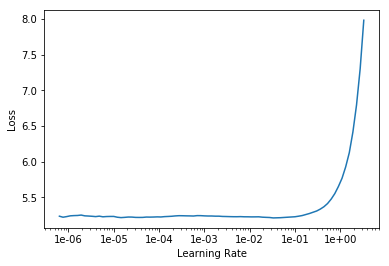

In [9]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

Total time: 52:29
epoch  train_loss  valid_loss  accuracy
1      4.721628    4.533323    0.245440  (52:29)



In [11]:
learn.save('fit_head')

In [8]:
learn.load('fit_head');

In [9]:
learn.predict("I want to like this movie", 75, temperature = 1.1, min_p= 0.001)

'I want to like this movie , the movie , and the city of " a " with a strong , in the only that the old - the most recent generations of the idea for the first - the story - the rest of the city of course , the film and the time when it was extremely close to die hard to come - more times through the way into a little , the first on . \n\n one'

In [10]:
learn.save_encoder('fit_head_enc')

# Building the classifier

Now we'll create a data object that only grabs the labelled data and keeps those labels.

In [11]:
(path/'train').ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/neg'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsup')]

In [12]:
data_class = (TextList.from_folder(path, vocab = data_lm.vocab)
             # Grabs all the text files from the folder
             .split_by_folder(valid = 'test')
              # This splits by train and test folder (which is our validation folder), so no need to filter
             .label_from_folder(classes = ['neg', 'pos'])
             .filter_missing_y()
             .databunch(bs = bs))

data_class.save('tmp_class')

TypeError: 'bool' object is not callable

## Note that we got an error in the above code, beause filter_missing_y is a boolean object of that function, hence cannot be called. The solution is to separate out each operation in separate lines.

In [13]:
text_list = TextList.from_folder(path, vocab = data_lm.vocab)

In [14]:
txt_split_by_folder = text_list.split_by_folder(valid = 'test')

In [15]:
txt_labeled_by_folder = txt_split_by_folder.label_from_folder(classes = ['neg', 'pos'])

In [16]:
txt_labeled_by_folder.filter_missing_y = True

In [17]:
data_class = txt_labeled_by_folder.databunch(bs = bs)

In [18]:
data_class.save('tmp_class')

In [20]:
len(data_class.train_dl)

1389

In [21]:
data_class = TextDataBunch.load(path, 'tmp_class', bs = bs)

In [22]:
data_class.show_batch()

text,target
xxbos xxunk match 1 : xxunk tag xxunk team xxunk table xxunk match xxunk bubba xxunk ray and xxunk spike xxunk dudley vs xxunk eddie xxunk guerrero and xxunk chris xxunk benoit xxunk bubba xxunk ray and xxunk spike xxunk dudley started things off with a xxunk tag xxunk team xxunk table xxunk match against xxunk eddie xxunk guerrero and xxunk chris xxunk benoit . xxunk according to the rules,pos
"xxbos xxunk here are the matches . . . ( adv . = advantage ) \n\n xxunk the xxunk warriors ( xxunk ultimate xxunk warrior , xxunk texas xxunk tornado and xxunk legion of xxunk doom ) v xxunk the xxunk perfect xxunk team ( xxunk mr xxunk perfect , xxunk ax , xxunk smash and xxunk crush of xxunk demolition ) : xxunk ax is the first to go",neg
"xxbos xxunk prior to this release , xxunk neil labute had this to say about the 1973 original : "" xxunk it 's surprising how many people say it 's their favorite soundtrack . i 'm like , come on ! xxunk you may not like the new one , but if that 's your favorite soundtrack , i do n't know if i * want * you to like",neg
"xxbos i felt duty bound to watch the 1983 xxunk timothy xxunk dalton / xxunk zelah xxunk clarke adaptation of "" xxunk jane xxunk eyre , "" because i 'd just written an article about the 2006 xxup bbc "" xxunk jane xxunk eyre "" for xxunk . \n\n xxunk so , i approached watching this the way i 'd approach doing homework . \n\n i was irritated at first",pos
"xxbos xxunk my former xxunk cambridge contemporary xxunk simon xxunk xxunk , today a writer and journalist , has put forward the theory that , just as xxunk british film - makers in the eighties were often critical of what they called "" xxunk thatcher 's xxunk britain "" , the xxunk ealing comedies were intended as satires on "" xxunk xxunk 's xxunk britain "" , the xxunk britain",pos


Now we create the model to classify these reviews by loading the previous language model

In [24]:
learn = text_classifier_learner(data_class, drop_mult=0.5)
learn.load_encoder('fit_head_enc')
learn.freeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


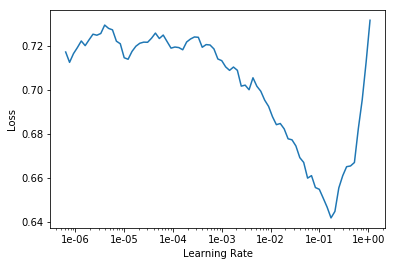

In [26]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(1, 2e-2, moms = (0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.562946,0.433980,0.820480


Note that the accuracy is very low, compared to others. That's because we haven't yet fine-tuned the language model. And that was because of time constraint - the model was taking too long to train on our GPU

In [28]:
learn.save('first')

In [30]:
learn.load('first');

In [31]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.434268,0.305233,0.872760


In [32]:
learn.save('second')

In [33]:
learn.predict("I really loved that move. It was awesome!")

(Category pos, tensor(1), tensor([0.0014, 0.9986]))

In [34]:
learn.predict("This movie was so bad, that it was actually good")

(Category neg, tensor(0), tensor([9.9992e-01, 8.0688e-05]))